In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

#### Se Carga la cuenta para poder realizar las simulaciones
IBMQ.load_account()
####-----####



In [2]:
%matplotlib inline
# Librerías estandar de Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *

#Librería para optimizar el circuito que se diseñe
from qiskit.compiler import transpile, assemble

#Librerias para el trabajo en el dispositivo real
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ

#Librerias para la visualización por medio de la esfera de Bloch y de histogramas
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city

## Librerías para la visualización de Vectores y matrices
###Display usando markdown
import numpy as np
from IPython.display import display, Markdown, Latex
from array_to_latex import to_ltx
###Otros Display
from herramientas.tools import vector2latex
from herramientas.learn_quantum import format_state_vector
from herramientas.learn_quantum import print_short_state_vector
from herramientas.tools import unitary2latex



In [3]:
from herramientas.tools import unitary2latex2 #Funcion creada para poder visualizar la parte imaginaria



In [4]:
## Se configura la forma de visualizar los vectores con el uso latex y markdown
latex_formatter = get_ipython().display_formatter.formatters["text/latex"]
latex_formatter.for_type(np.ndarray, lambda m: to_ltx(m, print_out=False))



In [53]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose()

import math
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cu1(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)
        
        

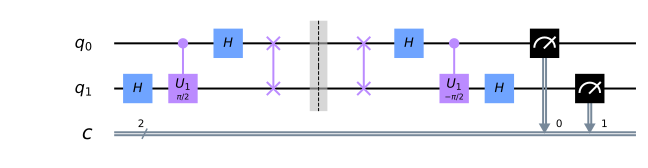

In [88]:
qcn=QuantumCircuit(2,2)
#qcn.x(0)
#qcn.x(1)
qft(qcn,2)
qcn.barrier()
qft_dagger(qcn,2)
qcn.measure(0,0)
qcn.measure(1,1)
qcn.draw('mpl')



In [89]:
counts = execute(qcn,Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)



{'00': 1024}


In [96]:
qc = QuantumCircuit(4,4)
qc.x(0)
qc.x(3)
#qc.barrier()
####
qc.swap(0,1)
qc.h(0)
qc.cu1(np.pi/2, 1, 0) # CROT from qubit 1 to qubit 2
qc.h(1)
#qc.draw('mpl')



In [97]:
qc.cu1(np.pi/2, 0, 2)
qc.cu1(np.pi, 0, 3)
qc.cu1(np.pi/2, 1, 3)
#qc.barrier()
#qc.draw('mpl')



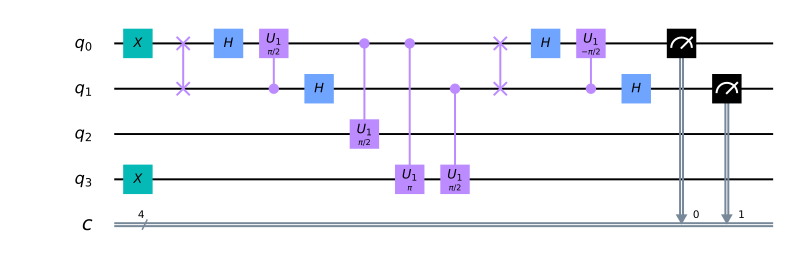

In [98]:
qc.swap(0,1)
qc.h(0)
qc.cu1(-np.pi/2, 1, 0) # CROT from qubit 1 to qubit 2
qc.h(1)

qc.measure(0,0)
qc.measure(1,1)
#qc.measure(2,2)
#qc.measure(3,3)

qc.draw('mpl')



In [99]:
counts = execute(qc,Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)



{'0000': 269, '0010': 245, '0011': 510}


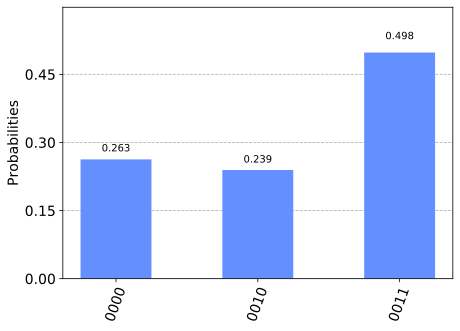

In [100]:
plot_histogram(counts)



## Simulación sobre el IBMQ 16 Q-bits

* Simulación sin optimización

In [101]:
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor


provider = IBMQ.get_provider(hub='ibm-q')

real_device='ibmq_16_melbourne'
device=IBMQ.get_provider('ibm-q').get_backend(real_device)
job = execute(qc, backend= device, shots=1024)
print(job.job_id())
job_monitor(job)



5eadb4239f981a00121e0ac6
Job Status: job has successfully run


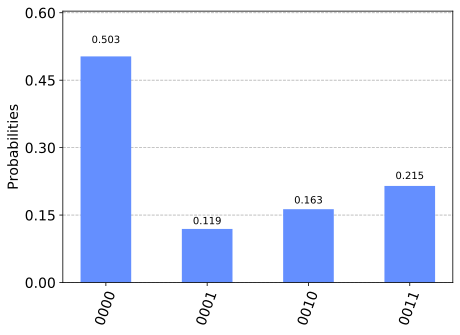

In [102]:
results=job.result()
plot_histogram(results.get_counts(qc))



* Simulación con Optimización

In [103]:
device=IBMQ.get_provider('ibm-q').get_backend(real_device)
new_qc=transpile(qc, device, optimization_level=3)

job = execute(new_qc, backend= device, shots=1024)
print(job.job_id())
job_monitor(job)



5eadbb3b5b4fb90012f8033e
Job Status: job has successfully run


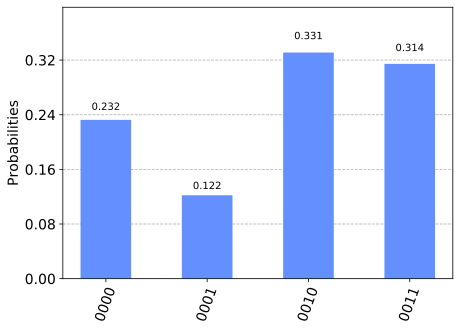

In [104]:
results=job.result()
plot_histogram(results.get_counts(qc))

